In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import pandas as pd

In [51]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [53]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")
conn = engine.connect()

# reflect an existing database into a new model

In [54]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [55]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [59]:
# Taking a look at the first row of the station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff5a1f364d0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [60]:
# Taking a look at the first row of the station table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff5a1f38050>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

# Exploratory Climate Analysis

In [61]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date)[-1]
last_date

('2017-08-23')

In [62]:
# Perform a query to retrieve the data and precipitation scores
# Many props to David Fried (from my group one project) for talking me through this section and his awesome code!
last_date = str(last_date).replace(')','').replace('(','').replace("'",'')
year, month, day = str(last_date).split('-')
year = int(year) - 1
month = month.replace(',','')
day = day.replace(',','')
year_ago = dt.date(year, int(month), int(day))
dates = []
precipitation = []
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago):
    dates.append(row[0])
    precipitation.append(row[1])

In [63]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({'Date': dates, 'Precipitation': precipitation}).set_index('Date')

In [64]:
# Sort the dataframe by date
df.sort_values('Date', inplace=True)

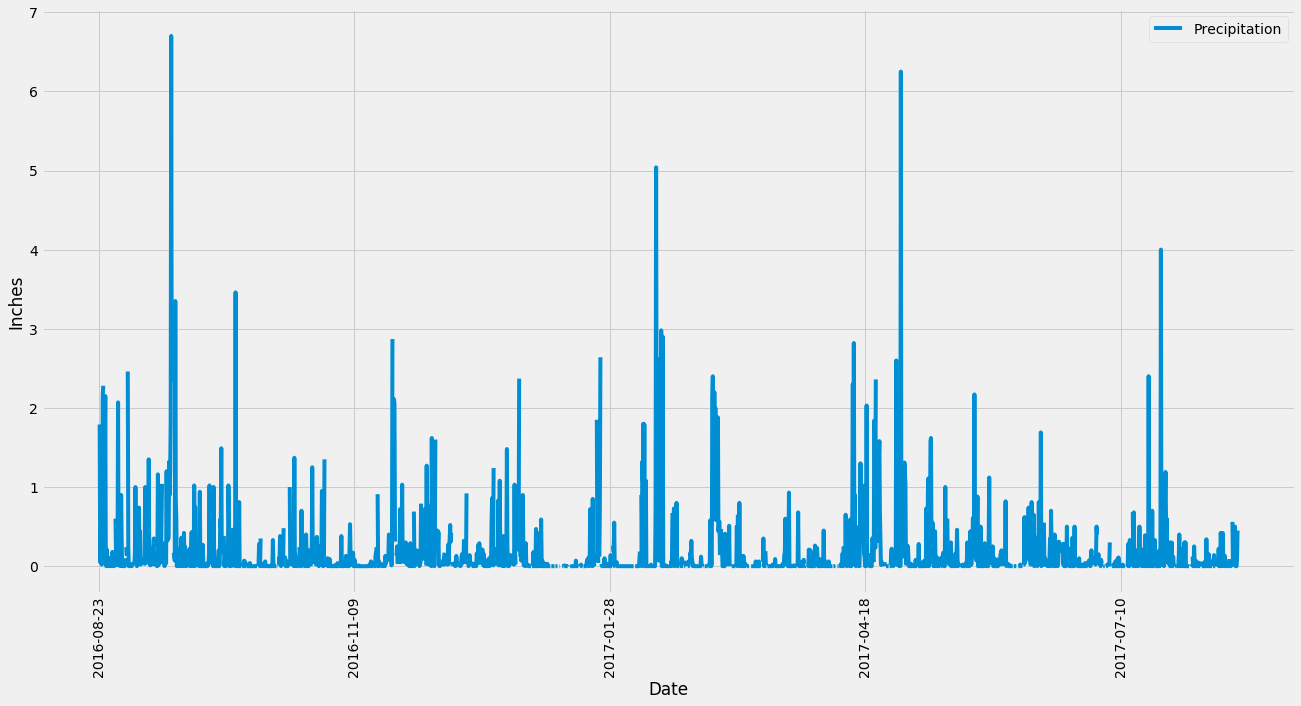

In [65]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize =(20,10), rot=90)
plt.ylabel('Inches')
plt.show()

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()  

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [67]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).count()
stations

19550

In [68]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

count_ = func.count('*')

results = session.query(Measurement.station, count_).\
        filter(Measurement.station != '').\
        group_by(Measurement.station).\
        order_by(count_.desc()).all()
station = []
station_count = []

for r in results:
    station.append(r[0])
    station_count.append(r[1])

station_df = pd.DataFrame({'Station ID': station, 'Station Count': station_count}).set_index('Station ID')    
station_df


,Station Count
Station ID,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The lowest temp is {min_temp}")

The lowest temp is (54.0,)


In [77]:
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The highest temp is {max_temp}")

The highest temp is (85.0,)


In [83]:
avgr_temp = session.query(func.round(func.avg(Measurement.tobs))).filter(Measurement.station == 'USC00519281').first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The average temp is {avg_temp} or {avgr_temp} rounded.")

The average temp is (71.66378066378067,) or (72.0,) rounded.


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
